In [25]:
import glob
import os
import scanpy as sc
import numpy as np
import tqdm
import gc
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
import scipy

## Get list of relevant TFs that are expressed

In [3]:
data_path = '/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data'

In [4]:
tf_masterlist = pd.read_table(os.path.join(data_path, 'motif_effects/tf_masterlist.tsv'))

In [5]:
tf_masterlist

,tfclass:id,tfclass:superclass,tfclass:class,tfclass:family,tfclass:subfamily,curated:uniprot_ac,tfclass:source,curated:uniprot_id,auto:protein_name,auto:gene_symbol,auto:gene_synonyms,auto:hgnc,auto:mgi,auto:entrez,GRECO_dbTF
0,0.0.0.0.256,Yet undefined DNA-binding domains,Uncharacterized,MBD factors,CpG-binding,Q9UBB5,manual,MBD2_HUMAN,Methyl-CpG-binding domain protein 2,MBD2,NaN,6917;,NaN,8932;,no
1,0.0.0.0.256,Yet undefined DNA-binding domains,Uncharacterized,MBD factors,CpG-binding,Q9Z2E1,manual,MBD2_MOUSE,Methyl-CpG-binding domain protein 2,Mbd2,NaN,NaN,1333813;,17191;,no
2,0.0.0.0.257,Yet undefined DNA-binding domains,Uncharacterized,MBD factors,CpG-binding,O95983,manual,MBD3_HUMAN,Methyl-CpG-binding domain protein 3,MBD3,NaN,6918;,NaN,53615;,no
3,0.0.0.0.257,Yet undefined DNA-binding domains,Uncharacterized,MBD factors,CpG-binding,Q9Z2D8,manual,MBD3_MOUSE,Methyl-CpG-binding domain protein 3,Mbd3,NaN,NaN,1333812;,17192;,no
4,0.0.0.0.258,Yet undefined DNA-binding domains,Uncharacterized,MBD factors,CpG-binding,O95243,manual,MBD4_HUMAN,Methyl-CpG-binding domain protein 4,MBD4,NaN,6919;,NaN,8930;,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,9.1.1.1.1,beta-Barrel DNA-binding domains,Cold-shock domain factors,Dbp,A,Q9JKB3,http://tfclass.bioinf.med.uni-goettingen.de/,YBOX3_MOUSE,Y-box-binding protein 3 (Cold shock domain-con...,Ybx3,Csda Msy4,NaN,2137670;,56449;,no
2677,9.1.1.2.1,beta-Barrel DNA-binding domains,Cold-shock domain factors,Dbp,B,P67809,http://tfclass.bioinf.med.uni-goettingen.de/,YBOX1_HUMAN,Y-box-binding protein 1 (YB-1) (CCAAT-binding ...,YBX1,NSEP1 YB1,8014;,NaN,4904;,no
2678,9.1.1.2.1,beta-Barrel DNA-binding domains,Cold-shock domain factors,Dbp,B,P62960,http://tfclass.bioinf.med.uni-goettingen.de/,YBOX1_MOUSE,Y-box-binding protein 1 (YB-1) (CCAAT-binding ...,Ybx1,Msy-1 Msy1 Nsep1 Yb1,NaN,99146;,22608;,no
2679,9.1.1.3.1,beta-Barrel DNA-binding domains,Cold-shock domain factors,Dbp,C,Q9Y2T7,http://tfclass.bioinf.med.uni-goettingen.de/,YBOX2_HUMAN,Y-box-binding protein 2 (Contrin) (DNA-binding...,YBX2,CSDA3 MSY2,17948;,NaN,51087;,no


In [6]:
df = pd.read_csv(
    os.path.join(data_path, 'epicardioids_training_data', 'DEG_gene_sequences.csv'),
    sep='\t',
    header=None
)

## Load motifs and plot

In [7]:
motif_path = os.path.join(data_path, 'motif_effects/epicardiods_motif_effects')

In [8]:
adata = sc.read(
    os.path.join(data_path, 'epicardioids_training_data', 'adata_matched.h5ad'), 
    gex_only=False
)

In [9]:
if False:
    norm_factor_rna = ad_ref.obs['size_factor_rna'].values[:, None]
    all_tfs = [x for x in glob.glob(f'{motif_path}*multiome.h5ad') if 'ref_multiome' not in x]
    ad_alt_df = dict()
    ad_alt = dict()
    ad_ref = sc.read(os.path.join(motif_path, 'ref_multiome.h5ad'))
    ad_ref = ad_ref[adata.obs_names]
    median_sf_rna=np.median(ad_ref.X.sum(axis=1))

    sc.pp.normalize_total(ad_ref, target_sum=median_sf_rna, key_added='size_factor_rna')  
    for i, tf_path in tqdm.tqdm(enumerate(all_tfs)):
        ad_alt = sc.read(tf_path)
        motif_name = os.path.basename(tf_path).split('alt_')[1].split('_multiome.h5ad')[0]
        name = tf_path.split('alt_')[1].split('.')[0]
        ad_alt = ad_alt[adata.obs_names]
    
        ad_alt.X = ad_alt.X/norm_factor_rna * median_sf_rna
    
        motif_rna = (np.log2(ad_ref.X+1) - np.log2(ad_alt.X+1)).mean(axis=1).squeeze()
        ad_alt_df[name] = dict()
        ad_alt_df[name]['rna_difference'] = motif_rna
        gc.collect()
    
    results = pd.DataFrame(ad_alt_df).T
    results = results.reset_index().rename({"index" : "TF"}, axis = 1)
    results.to_parquet(os.path.join(motif_path, "TF_motif_effect_scores.pq"))
else:
    results = pd.read_parquet(os.path.join(motif_path, "TF_motif_effect_scores.pq"))

In [10]:
for i, row in results.iterrows():
    adata.obs['TF_' + row['TF']] = row['rna_difference'].astype(float)

## Plot UMAP

In [11]:
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False, vector_friendly=True)

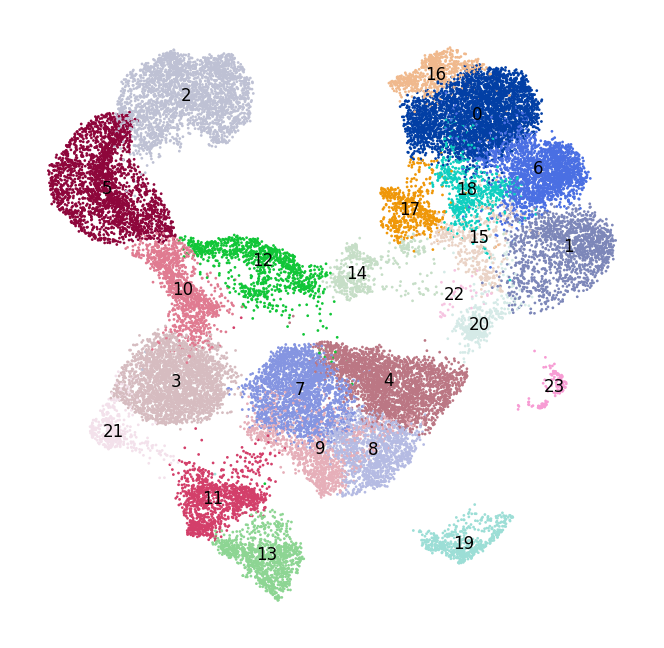

In [12]:
fig, ax = plt.subplots(figsize=(4,4))
sc.pl.umap(adata, color='leiden_res1', legend_loc='on data', legend_fontsize=6, legend_fontweight='normal', ax =ax, title="")
fig.savefig("../figures/Figure3/epicardiods_umap.svg", dpi=600)

## Plot scooby scores

In [13]:
adata_epi = adata[adata.obs.leiden_res1 =='14'].copy()

In [14]:
for i, row in results.iterrows():
    adata_epi.obs['TF_' + row['TF']] = sklearn.preprocessing.minmax_scale(adata_epi.obs['TF_' + row['TF']])

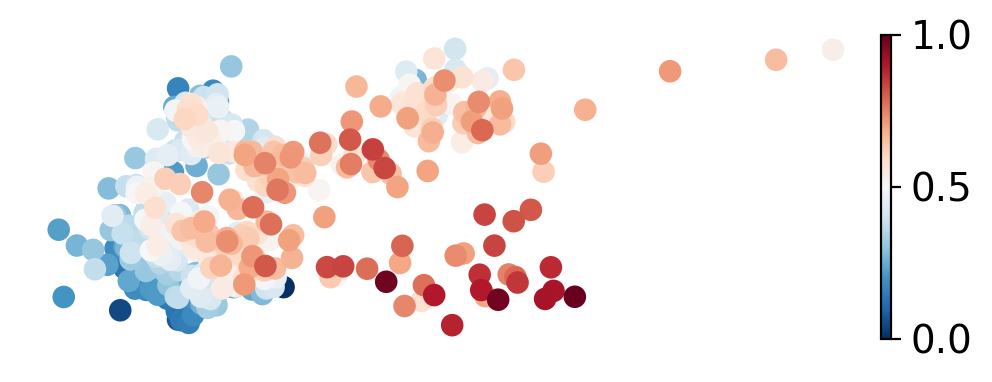

In [16]:
fig, ax = plt.subplots(figsize=(6, 2))
sc.pl.umap(adata_epi, color=['TF_GATA4'], ax=ax, cmap='RdBu_r', title="")
fig.savefig("../figures/Figure3/GATA4_scooby.svg", dpi=600, bbox_inches='tight')

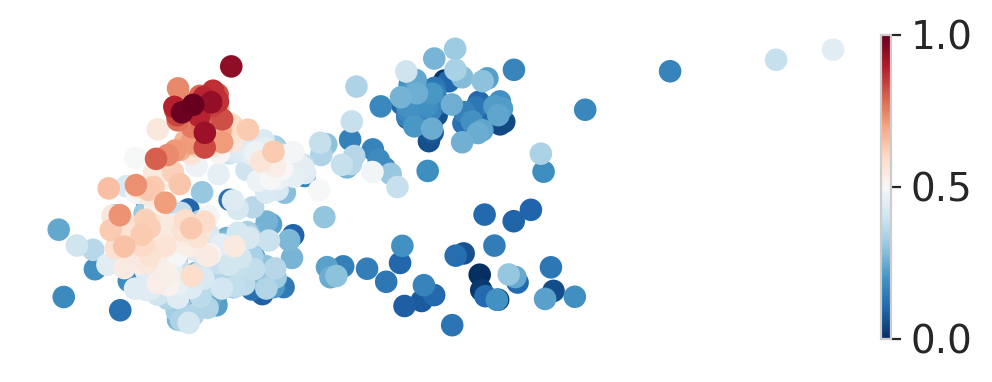

In [32]:
fig, ax = plt.subplots(figsize=(6, 2))
sc.pl.umap(adata_epi, color=['TF_FOS'], ax=ax, cmap='RdBu_r', title="")
fig.savefig("../figures/Figure3/FOS_scooby.svg", dpi=600, bbox_inches='tight')

## Plot absorption probability

In [19]:
absorption_prob = pd.read_csv(os.path.join(motif_path, 'absorption_prob.csv'), index_col=0)

In [20]:
adata_epi.obs = adata_epi.obs.join(absorption_prob )

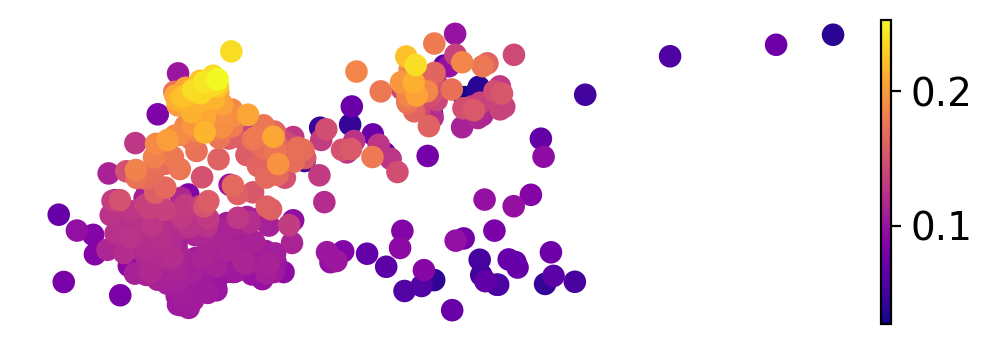

In [21]:
fig, ax = plt.subplots(figsize=(6, 2))
sc.pl.umap(adata_epi, color='Epicardial', ax=ax, cmap='plasma', title="")
fig.savefig("../figures/Figure3/absorption_epi.svg", dpi=600)

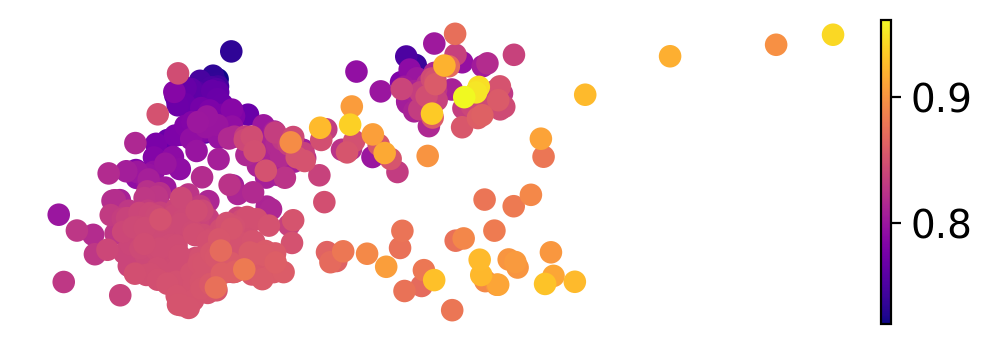

In [22]:
fig, ax = plt.subplots(figsize=(6, 2))
sc.pl.umap(adata_epi, color='Cardiomyocyte', ax=ax, cmap='plasma', title="")
fig.savefig("../figures/Figure3/absorption_cm.svg", dpi=600)

In [23]:
#correlate fate probabilities with TF scores
tfs = adata_epi.obs.columns[adata_epi.obs.columns.str.contains('TF_')]

In [26]:
corr_epi = {tf.split('TF_')[1]: scipy.stats.pearsonr(adata_epi.obs[tf], adata_epi.obs['Epicardial']).statistic for tf in tfs}

In [27]:
corr_epi = pd.DataFrame(corr_epi, index=['corr']).T.sort_values('corr')

In [28]:
corr_cm = {tf.split('TF_')[1]: scipy.stats.pearsonr(adata_epi.obs[tf], adata_epi.obs['Cardiomyocyte']).statistic for tf in tfs}

In [29]:
corr_cm = pd.DataFrame(corr_cm, index=['corr']).T.sort_values('corr')

In [30]:
sns_df = corr_cm.join(corr_epi, rsuffix='_epi').melt(ignore_index=False)

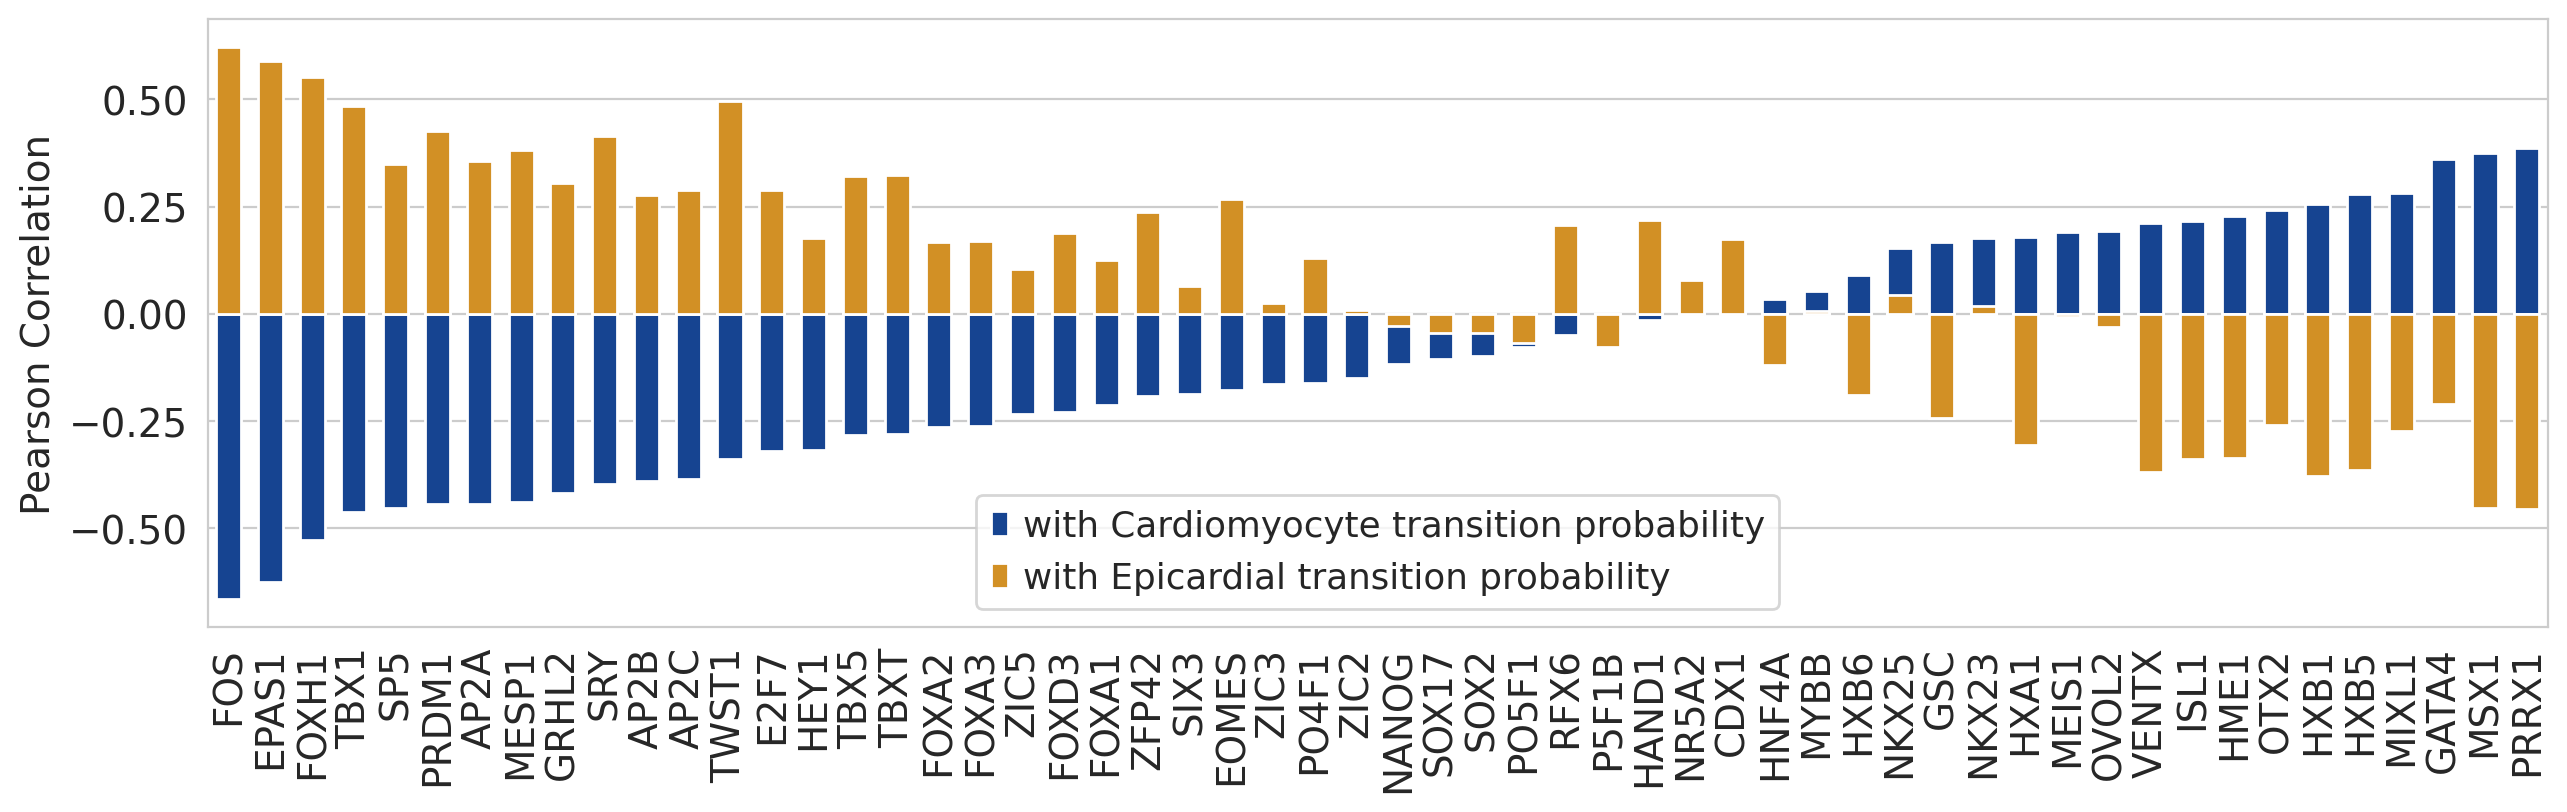

In [31]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15, 4))
g = sns.barplot(data=sns_df.reset_index(), x='index', y='value', hue='variable', dodge=False, palette=['#023fa5', '#ef9708'], width=0.6)
plt.xticks(rotation=90);
plt.ylabel('Pearson Correlation')
plt.xlabel('')
# Correct way to change legend labels:
handles, labels = g.get_legend_handles_labels()  # Get handles and current labels
g.legend(handles=handles, labels=["with Cardiomyocyte transition probability", "with Epicardial transition probability"], title='') # Set the new labels
fig.savefig("../figures/Figure3/correlations_tfs.svg", dpi=600, bbox_inches='tight')